In [ ]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy
import matplotlib.pyplot as plt

## here are the user-defined functions and classes
from MarkovComputations import WeightMatrix, InputData, get_input_inds, get_output_inds, random_initial_parameters, compute_error

In [31]:
#########################################################
################  Parameter definitions #################
#########################################################

random.seed(20)

### Define parameters of classification
M = 1 # how many edges affected per input dimension
n_classes = 2 # D, how many classes
input_dim = 1 # D, how many components of each input data

### Define parameters of graph object and initial weights
n_nodes = 10 # assuming a complete graph
E_range = 0 # range of uniform distribution for Ej, etc.
B_range = 0
F_range = 0

### Define parameters of trainig
n_training_iters = 500 # how many training steps to take
eta = 1 # learning rate (increment of Ej, Bij, Fij)
delta_E = 1 # nuding factor (change in Ej at output nodes during nudging)

############################################################
################  Initialize weight_matrix #################
############################################################

## create graph
g = nx.complete_graph(n_nodes) # assuming a complete graph for now - easy to change
n_edges = len(list(g.edges())) 

## get input and output inds
output_inds = get_output_inds(n_nodes, n_classes, False)
input_inds = get_input_inds(n_edges, input_dim, M)

## initialize first edge rates
Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

# Create WeightMatrix object
weight_matrix = WeightMatrix(g, Ej_list, Bij_list, Fij_list)
weight_matrix.lower_output_energies(output_inds, 2) # lower energies at the output nodes to ease training


############################################################
################  Load classification data #################
############################################################

######  Gaussian example
n_samples = 20000

### one-dimensional example
n_samples = 20000
mu_1 = 10
sigma_1 = 1
dist_1 = np.random.normal(mu_1, sigma_1, n_samples)

mu_2 = -10
sigma_2 = 1
dist_2 = np.random.normal(mu_2, sigma_2, n_samples)

data_list = [[[dat] for dat in dist_1], [[dat] for dat in dist_2]]

### two-dimensional example
# mu_1 = [-10, -10]
# cov_1 = 1.0 * np.array([[1, 0], [0, 1]])
# dist_1 = np.random.multivariate_normal(mu_1, cov_1, n_samples)

# mu_2 = [10, 10]
# cov_2 = 1.0 * np.array([[1, 0], [0, 1]])
# dist_2 = np.random.multivariate_normal(mu_2, cov_2, n_samples)

# data_list = [[dat for dat in dist_1], [dat for dat in dist_2]]


###  create InputData object
input_data = InputData(n_classes, data_list)



In [ ]:
################################################
################  Run training #################
################################################

weight_matrix_orig = copy.deepcopy(weight_matrix) # save original rate matrix 

error_list = [] # track errors during training

for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes) # draw a random class label to present
    inputs = next(input_data.training_data[class_number]) # get the next data point from the iterator for this class

    ss = weight_matrix.compute_ss_on_inputs(input_inds, inputs) # apply the data as input and get the steady state
    error_list.append(np.linalg.norm(compute_error(ss, input_data, class_number, output_inds))) # save error of this iteration
    nudged_ss = weight_matrix.compute_nudged_ss(input_data, class_number, input_inds, inputs, output_inds, delta_E) # get the steady state after applying a nudge on this input
    ss_frac = nudged_ss / ss # compute pi_nudge / pi
    
    weight_matrix.update(input_inds, inputs, ss_frac, eta) # update the weight_matrix
    

   
    

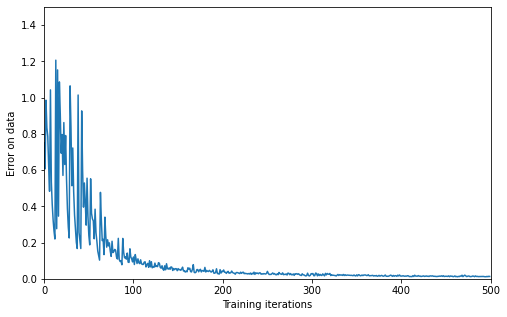

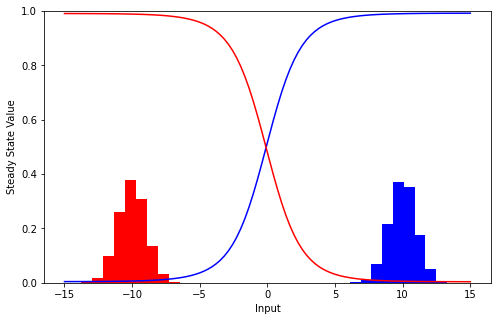

In [35]:
################################################
################  Plot results #################
################################################

### plot the error
plt.figure(figsize=(8, 5))
plt.plot(error_list)
plt.xlabel("Training iterations")
plt.ylabel("Error on data")
plt.ylim(0,1.5)
plt.xlim(0,n_training_iters)
plt.show()


# Define a range of input values
x_values = np.linspace(-15, 15, 100)  # Adjust range as needed
ss_values = np.zeros((len(x_values), len(output_inds)))


out_ind = 1
for (i, x) in enumerate(x_values):
    ss = weight_matrix.compute_ss_on_inputs(input_inds, [x])
    ss_at_outputs = [ss[out] for out in output_inds]
    ss_values[i,:] = ss_at_outputs  # Assuming node index 1 is of interest


# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x_values, ss_values[:,0], label="Steady State at Node 1", color='b')
plt.plot(x_values, ss_values[:,1], label="Steady State at Node 2", color='r')

plt.hist(dist_1, density=True, color='b')
plt.hist(dist_2, density=True, color='r')

plt.xlabel("Input")
plt.ylabel("Steady State Value")
plt.ylim(0,1.)
#plt.legend()
plt.show()



In [19]:
np.array(ss_values)

array([[0.99190533, 0.00397177],
       [0.9918784 , 0.00399829],
       [0.9918477 , 0.00402871],
       [0.9918117 , 0.00406446],
       [0.99177134, 0.0041054 ],
       [0.9917232 , 0.00415342],
       [0.99166685, 0.00420971],
       [0.99160093, 0.00427531],
       [0.99152493, 0.00435119],
       [0.9914358 , 0.00443996],
       [0.99133307, 0.00454307],
       [0.99121225, 0.00466356],
       [0.99107224, 0.00480396],
       [0.99090743, 0.00496811],
       [0.9907166 , 0.00515929],
       [0.99049276, 0.00538273],
       [0.99023163, 0.00564382],
       [0.98992646, 0.00594914],
       [0.98956835, 0.00630657],
       [0.98914915, 0.0067253 ],
       [0.988658  , 0.00721598],
       [0.98808265, 0.00779145],
       [0.987406  , 0.00846769],
       [0.986608  , 0.00926447],
       [0.98567003, 0.01020231],
       [0.9845608 , 0.0113103 ],
       [0.9832495 , 0.01262069],
       [0.9816958 , 0.01417357],
       [0.9798494 , 0.01601885],
       [0.97764814, 0.01821809],
       [0.